# Fast Gradient Sign Method

Functions used:

`attack_FGSM`

`visualize_attack_FGSM`

`get_attack_series`

`confidence_range_attack_FGSM`

`single_attack_stats_FGSM`

`analyze_attack_FGSM`

`all_samples_attack_FGSM`

`iterate_epsilons_FGSM`

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import models
from torchvision import transforms

#plt.rcParams['figure.figsize'] = (20.0, 10.0)
from IPython.display import clear_output


# Import helper functions
from modules.helper import *
from modules.dataset import ImageNetSubset
from modules.fgsm import*

## 0. Load Model and Data

We load the pre-trained googleNet and the data.

In [3]:
# Load model and data
model = models.googlenet(pretrained=True)
model.eval();

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]   

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

data_loader = torch.utils.data.DataLoader(
    ImageNetSubset("data/ImageNet_subset//dev_dataset.csv", "data/ImageNet_subset//images/", transform=preprocess))

## 1.Introduction

			Clean image	 Adversarial image

Actual class: 		barrel, cask			barrel, cask
Predicted class: 	barrel, cask			barrel, cask
Confidence: 		99.99%				14.81%



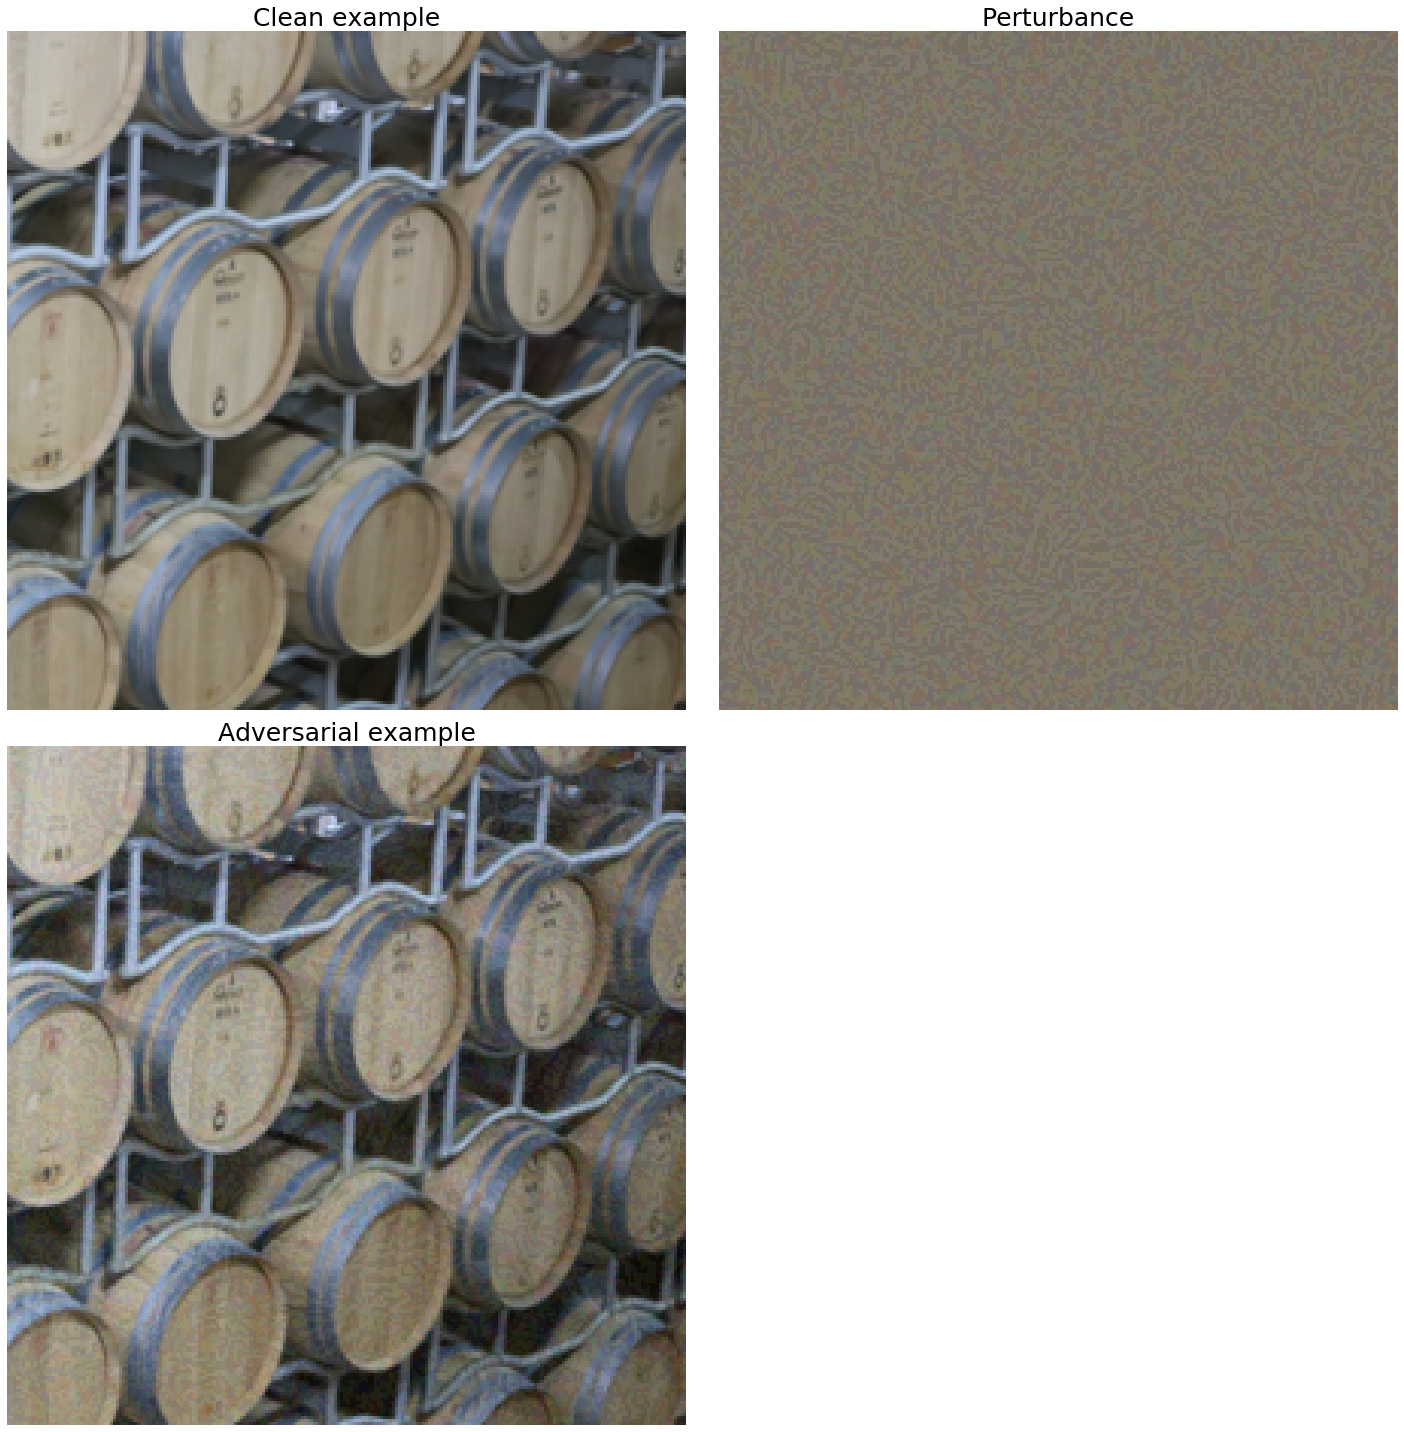

In [4]:
# Example with highest confidence
epsilon = 6/255
sample = 766

visualize_attack_FGSM(data_loader, mean, std, model, predict, epsilon, sample, summarize_attack, folder="FGSM")

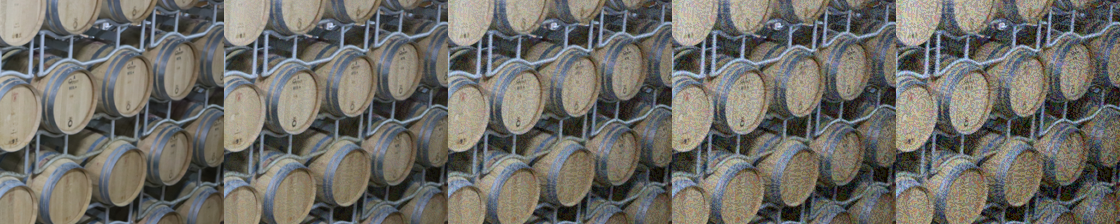

In [5]:
# Series of adversaries
sample = 766
epsilons = [4/255, 8/255, 12/255, 16/255]

images = get_attack_series(data_loader, mean, std, model, predict, epsilons, sample, show_tensor_image)
images

## 2. All Images

We are splitting the data according to the original confidences. For each of the intervals we craft adversarial examples at varying epsilon and report the confidence and accuracy of these attacks for the interval.


### 2.1 Confidence ranges

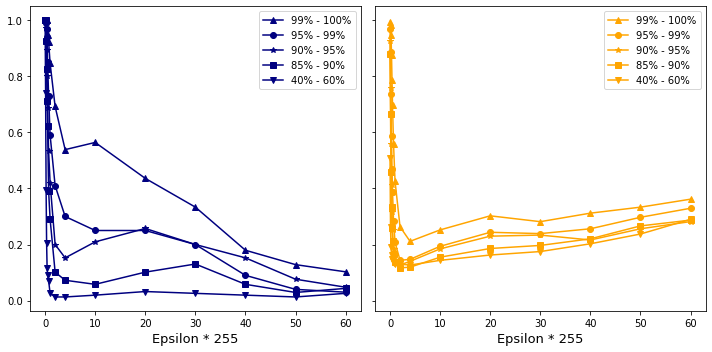

In [7]:
# Load data
result_99 = pd.read_csv("results/FGSM/FGSM-Conf99.csv")
result_95 = pd.read_csv("results/FGSM/FGSM-Conf95.csv")
result_90 = pd.read_csv("results/FGSM/FGSM-Conf90.csv")
result_85 = pd.read_csv("results/FGSM/FGSM-Conf85.csv") 
result_40 = pd.read_csv("results/FGSM/FGSM-Conf40.csv")

# Plot
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,5))

## Top left: Accuracies
axs[0].plot(result_99["Epsilon_255"], result_99["Accuracy Top 1"], "-^", color='navy', label='99% - 100%')
axs[0].plot(result_95["Epsilon_255"], result_95["Accuracy Top 1"], "-o", color='navy', label='95% - 99%')
axs[0].plot(result_90["Epsilon_255"], result_90["Accuracy Top 1"], "-*", color='navy', label='90% - 95%')
axs[0].plot(result_85["Epsilon_255"], result_85["Accuracy Top 1"], "-s", color='navy', label='85% - 90%')
axs[0].plot(result_40["Epsilon_255"], result_40["Accuracy Top 1"], "-v", color='navy', label='40% - 60%')
axs[0].legend()
axs[0].set_xlabel("Epsilon * 255", fontsize=13)

## Bottom left: Confidences
axs[1].plot(result_99["Epsilon_255"], result_99["Confidence"], "-^", color='orange', label='99% - 100%')
axs[1].plot(result_95["Epsilon_255"], result_95["Confidence"], "-o", color='orange', label='95% - 99%')
axs[1].plot(result_90["Epsilon_255"], result_90["Confidence"], "-*", color='orange', label='90% - 95%')
axs[1].plot(result_85["Epsilon_255"], result_85["Confidence"], "-s", color='orange', label='85% - 90%')
axs[1].plot(result_40["Epsilon_255"], result_40["Confidence"], "-v", color='orange', label='40% - 60%')
axs[1].legend()
axs[1].set_xlabel("Epsilon * 255", fontsize=13)

## Save plot
fig.tight_layout()
fig.savefig("plots/FGSM/FGSM-accuracies_confidences.png")

### 2.2 Including initial false predictions

We now also craft adversarial examples when the prediction for the clean sample is false as the authors of [1] did.

In [ ]:
epsilons = [0, 1/255, 2/255, 4/255, 8/255, 16/255, 32/255, 48/255, 64/255, 96/255, 128/255]
top1, top5, conf = all_samples_attack_FGSM(model, data_loader, predict, mean, std, epsilons)

In [5]:
fgsm = pd.read_csv("results/FGSM/FGSM-all_samples.csv", index_col=0)
fgsm

,Epsilon,Top1,Top5,Confidence
0,0.0,0.844,0.971,0.623875
1,1.0,0.186,0.376,0.162151
2,2.0,0.112,0.242,0.141127
3,4.0,0.086,0.186,0.139712
4,8.0,0.086,0.203,0.157142
5,16.0,0.100,0.243,0.185620
6,32.0,0.071,0.182,0.204372
7,48.0,0.030,0.097,0.252400
8,64.0,0.020,0.038,0.301466
9,96.0,0.004,0.017,0.326796


## 3. Individual Images

### 3.1 Confidence and correct/false class over epsilon for individual images

In [6]:
# All images: Only for correct initial classifiation we compute adversaries.
epsilons = [0, 1/255, 2/255, 4/255, 8/255, 16/255, 32/255]

result = pd.DataFrame()


# Find examples with correct initial prediction
samples = []

for sample in range(1000):
    image_clean, class_index = data_loader.dataset[sample]
    image_clean.unsqueeze_(0)
    class_index.unsqueeze_(0)
    
    predicted_classes, _, _ = predict(model, image_clean, class_index, return_grad=False)
        
    if predicted_classes[0] == class_index.squeeze().numpy():
        samples.append(sample)
        clear_output(wait=True)
        print("Identified correct clean predictions: {}".format(len(samples)))

        
result["Sample"] = samples


for epsilon in epsilons:   
    conf = []
    
    # Attack only if initial prediction is correct
    counter = 1
    for sample in samples:
        clear_output(wait=True)
        print("Epsilon " + str(epsilon*255))
        print("Processing sample {} of {}".format(counter, len(samples)))
        conf_adv, attack_success, label_adv = single_attack_stats_FGSM(data_loader, mean, std, model, predict, 
                                                                       epsilon, sample, idx_to_name)
        
        if attack_success == 0:
            conf.append(conf_adv)

        else:
            conf.append(0)

        counter += 1
        
        
    result["Epsilon " + str(int(epsilon*255))] = conf

result.to_csv("results/FGSM/FGSM-accuracies-corr_only.csv")

Epsilon 32.0
Processing sample 844 of 844


In [6]:
result = pd.read_csv("results/FGSM/FGSM-accuracies-corr_only.csv", index_col=0)
result

,Sample,Epsilon 0,Epsilon 1,Epsilon 2,Epsilon 4,Epsilon 8,Epsilon 16,Epsilon 32
0,0,0,0.151650,0.084236,0.041904,0.053289,0.087156,0.116786
1,2,0,0.000000,0.000000,0.000000,0.000000,0.117633,0.178253
2,3,0,0.162078,0.149533,0.106008,0.145719,0.106449,0.273595
3,4,0,0.018643,0.028133,0.017726,0.016589,0.039816,0.156885
4,5,0,0.053544,0.062070,0.121566,0.054464,0.054345,0.065629
...,...,...,...,...,...,...,...,...
839,994,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.088060
840,995,0,0.284941,0.437114,0.313043,0.058075,0.130124,0.439796
841,996,0,0.058664,0.081518,0.112703,0.081313,0.018361,0.020692
842,998,0,0.033604,0.040841,0.059820,0.063519,0.086933,0.084134


In [26]:
result["Epsilon 8"].max()

0.6915830969810486

#### 3.1.1 Predicted class invariant

Examples for samples where the FGSM is not able to change the class. We will see that other attacks are able to accomplish this.

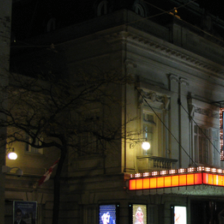

In [12]:
sample = 574

image_clean, class_index = data_loader.dataset[sample]
image_clean.unsqueeze_(0)
class_index.unsqueeze_(0)

show_tensor_image(image_clean)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9984958	honeycomb
0.1			1	0.99721515	honeycomb
0.2			1	0.9936559	honeycomb
0.3			1	0.98548675	honeycomb
0.4			1	0.9702776	honeycomb
0.5			1	0.94641435	honeycomb
0.7			1	0.87577116	honeycomb
1.0			1	0.7662984	honeycomb
2.0			1	0.6421063	honeycomb
3.0			1	0.6387259	honeycomb
4.0			1	0.63160247	honeycomb
5.0			1	0.64614445	honeycomb
6.0			1	0.68201077	honeycomb
8.0			1	0.80579555	honeycomb
10.0			1	0.9198083	honeycomb
12.0			1	0.9653693	honeycomb
14.0			1	0.9822119	honeycomb
16.0			1	0.9883703	honeycomb
18.0			1	0.99088913	honeycomb
20.0			1	0.9928846	honeycomb


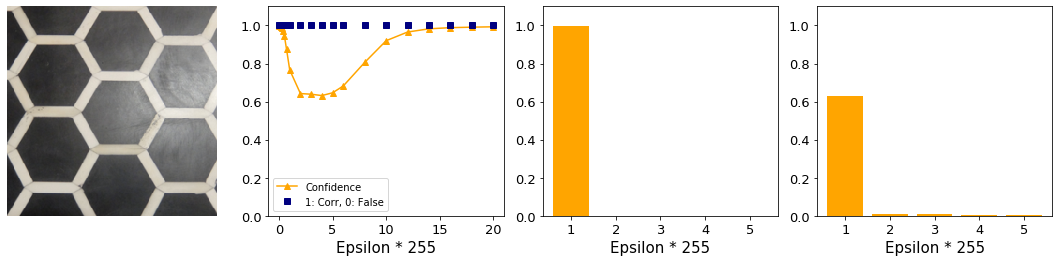

In [5]:
sample = 132
epsilon_conf = 4/255
analyze_attack_FGSM(data_loader, mean, std, model, predict, sample, epsilon_conf, 
                    show_tensor_image, idx_to_name, save_plot=True)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.8916601	oystercatcher, oyster catcher
0.1			1	0.7187698	oystercatcher, oyster catcher
0.2			1	0.54159766	oystercatcher, oyster catcher
0.3			1	0.41286704	oystercatcher, oyster catcher
0.4			1	0.3320735	oystercatcher, oyster catcher
0.5			1	0.27710265	oystercatcher, oyster catcher
0.7			1	0.21350215	oystercatcher, oyster catcher
1.0			1	0.17391019	oystercatcher, oyster catcher
2.0			1	0.17523278	oystercatcher, oyster catcher
3.0			1	0.23270682	oystercatcher, oyster catcher
4.0			1	0.24771328	oystercatcher, oyster catcher
5.0			1	0.29038793	oystercatcher, oyster catcher
6.0			1	0.3768897	oystercatcher, oyster catcher
8.0			1	0.5554285	oystercatcher, oyster catcher
10.0			1	0.6141285	oystercatcher, oyster catcher
12.0			1	0.62475955	oystercatcher, oyster catcher
14.0			1	0.64022845	oystercatcher, oyster catcher
16.0			1	0.6605509	oystercatcher, oyster catcher
18.0			1	0.6375172	oystercatcher, oyster catcher
20.0			1	0.5848905	oystercatcher, 

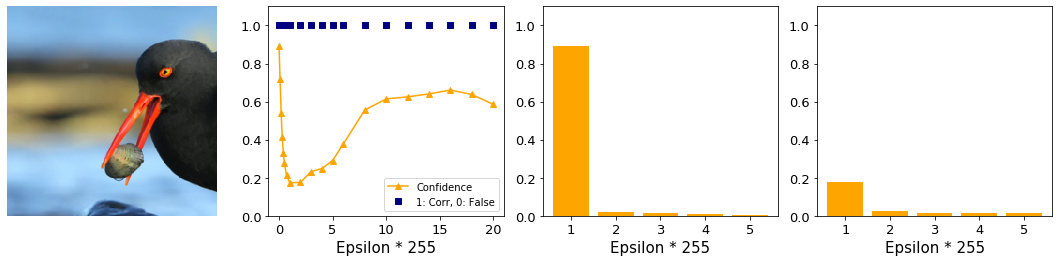

In [6]:
sample = 323
epsilon_conf = 2/255
analyze_attack_FGSM(data_loader, mean, std, model, predict, sample, epsilon_conf, 
                    show_tensor_image, idx_to_name, save_plot=True)

#### 3.1.2 Class bounces back

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9999355	barrel, cask
0.1			1	0.9997793	barrel, cask
0.2			1	0.9992168	barrel, cask
0.3			1	0.9974246	barrel, cask
0.4			1	0.992656	barrel, cask
0.5			1	0.9818143	barrel, cask
0.7			1	0.93215406	barrel, cask
1.0			1	0.75929576	barrel, cask
2.0			1	0.24853106	barrel, cask
3.0			1	0.1356677	barrel, cask
4.0			0	0.13086057	scale, weighing machine
5.0			1	0.12069081	barrel, cask
6.0			1	0.14814387	barrel, cask
8.0			1	0.23435521	barrel, cask
10.0			1	0.26709953	barrel, cask
12.0			1	0.3009068	barrel, cask
14.0			1	0.3354693	barrel, cask
16.0			1	0.27866164	barrel, cask
18.0			0	0.23515305	bottlecap
20.0			0	0.22546048	bottlecap


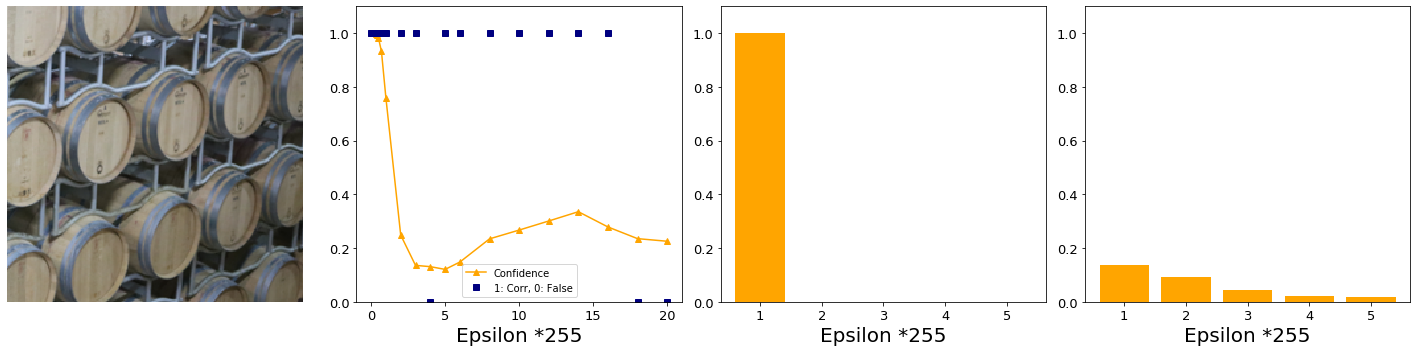

In [6]:
sample = 766
epsilon_conf = 3/255
analyze_attack_FGSM(data_loader, mean, std, model, predict, sample, epsilon_conf, 
                    show_tensor_image, idx_to_name, save_plot=False)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9999355	barrel, cask
0.1			1	0.9997793	barrel, cask
0.2			1	0.9992168	barrel, cask
0.3			1	0.9974246	barrel, cask
0.4			1	0.992656	barrel, cask
0.5			1	0.9818143	barrel, cask
0.7			1	0.93215406	barrel, cask
1.0			1	0.75929576	barrel, cask
2.0			1	0.24853106	barrel, cask
3.0			1	0.1356677	barrel, cask
4.0			0	0.13086057	scale, weighing machine
5.0			1	0.12069081	barrel, cask
6.0			1	0.14814387	barrel, cask
8.0			1	0.23435521	barrel, cask
10.0			1	0.26709953	barrel, cask
12.0			1	0.3009068	barrel, cask
14.0			1	0.3354693	barrel, cask
16.0			1	0.27866164	barrel, cask
18.0			0	0.23515305	bottlecap
20.0			0	0.22546048	bottlecap


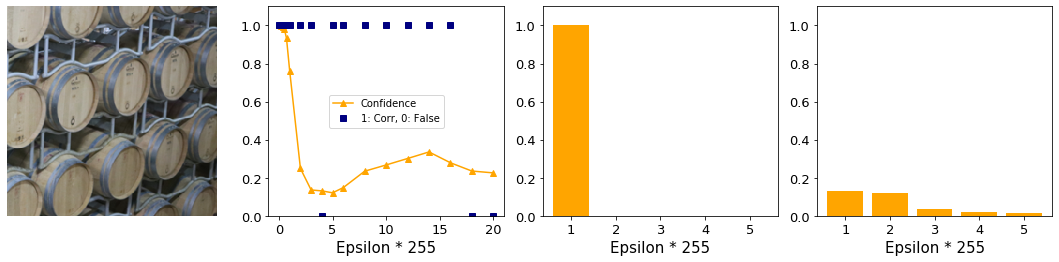

In [7]:
sample = 766
epsilon_conf = 4/255
analyze_attack_FGSM(data_loader, mean, std, model, predict, sample, epsilon_conf, 
                    show_tensor_image, idx_to_name, save_plot=True)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9999355	barrel, cask
0.1			1	0.9997793	barrel, cask
0.2			1	0.9992168	barrel, cask
0.3			1	0.9974246	barrel, cask
0.4			1	0.992656	barrel, cask
0.5			1	0.9818143	barrel, cask
0.7			1	0.93215406	barrel, cask
1.0			1	0.75929576	barrel, cask
2.0			1	0.24853106	barrel, cask
3.0			1	0.1356677	barrel, cask
4.0			0	0.13086057	scale, weighing machine
5.0			1	0.12069081	barrel, cask
6.0			1	0.14814387	barrel, cask
8.0			1	0.23435521	barrel, cask
10.0			1	0.26709953	barrel, cask
12.0			1	0.3009068	barrel, cask
14.0			1	0.3354693	barrel, cask
16.0			1	0.27866164	barrel, cask
18.0			0	0.23515305	bottlecap
20.0			0	0.22546048	bottlecap


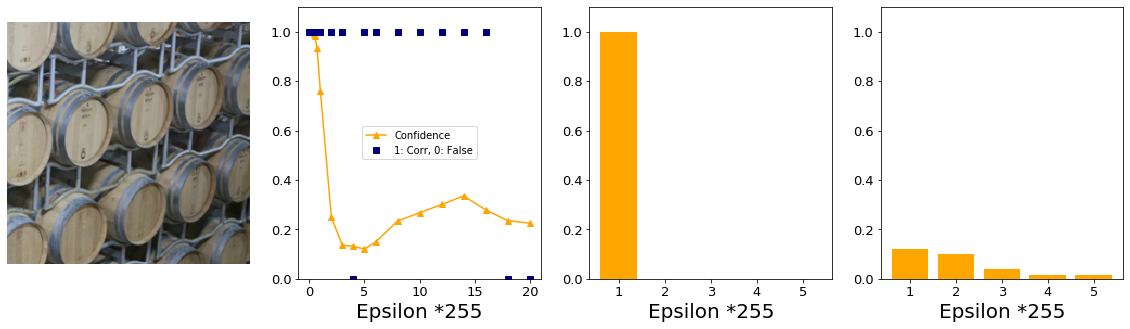

In [8]:
sample = 766
epsilon_conf = 5/255
analyze_attack_FGSM(data_loader, mean, std, model, predict, sample, epsilon_conf, 
                    show_tensor_image, idx_to_name, save_plot=False)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9999355	barrel, cask
0.1			1	0.9997793	barrel, cask
0.2			1	0.9992168	barrel, cask
0.3			1	0.9974246	barrel, cask
0.4			1	0.992656	barrel, cask
0.5			1	0.9818143	barrel, cask
0.7			1	0.93215406	barrel, cask
1.0			1	0.75929576	barrel, cask
2.0			1	0.24853106	barrel, cask
3.0			1	0.1356677	barrel, cask
4.0			0	0.13086057	scale, weighing machine
5.0			1	0.12069081	barrel, cask
6.0			1	0.14814387	barrel, cask
8.0			1	0.23435521	barrel, cask
10.0			1	0.26709953	barrel, cask
12.0			1	0.3009068	barrel, cask
14.0			1	0.3354693	barrel, cask
16.0			1	0.27866164	barrel, cask
18.0			0	0.23515305	bottlecap
20.0			0	0.22546048	bottlecap


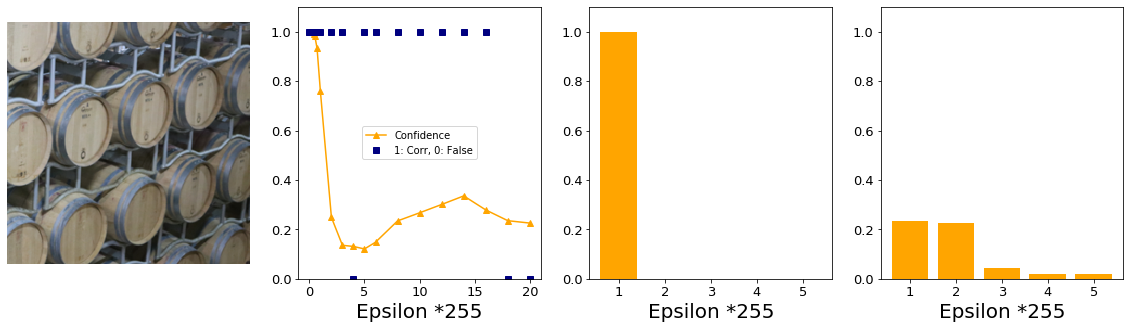

In [9]:
sample = 766
epsilon_conf = 18/255
analyze_attack_FGSM(data_loader, mean, std, model, predict, sample, epsilon_conf, 
                    show_tensor_image, idx_to_name, save_plot=False)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.89812696	apron
0.1			1	0.655235	apron
0.2			1	0.40885675	apron
0.3			1	0.26146814	apron
0.4			1	0.18003756	apron
0.5			0	0.16804919	lab coat, laboratory coat
0.7			0	0.19214581	lab coat, laboratory coat
1.0			0	0.20965621	lab coat, laboratory coat
2.0			0	0.2010445	lab coat, laboratory coat
3.0			0	0.19409224	lab coat, laboratory coat
4.0			0	0.19547743	lab coat, laboratory coat
5.0			0	0.19839363	lab coat, laboratory coat
6.0			0	0.20357373	lab coat, laboratory coat
8.0			0	0.19334966	lab coat, laboratory coat
10.0			0	0.1673113	lab coat, laboratory coat
12.0			1	0.22230485	apron
14.0			1	0.31577015	apron
16.0			1	0.41265127	apron
18.0			1	0.5240265	apron
20.0			1	0.6241006	apron


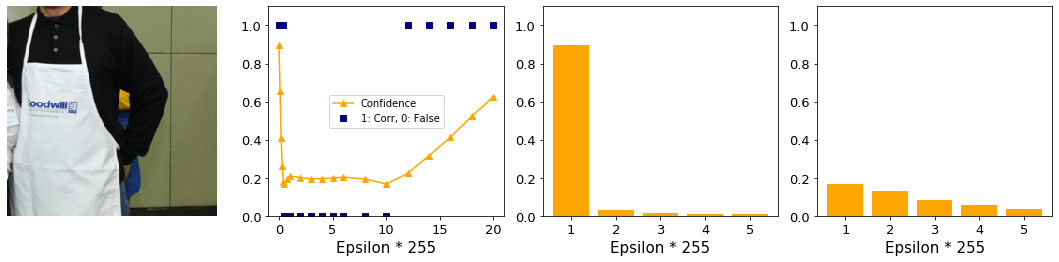

In [8]:
sample = 432
epsilon_conf = 0.5/255
analyze_attack_FGSM(data_loader, mean, std, model, predict, sample, epsilon_conf, 
                    show_tensor_image, idx_to_name, save_plot=True)

#### 3.1.3 Adversarial confidence greater than initial confidence

We try to find a sample where the adversarial confidence is greater than the initial confidence. We are not able to find such a sample in the data.

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.49230596	umbrella
0.1			0	0.61099654	lionfish
0.2			0	0.7307007	lionfish
0.3			0	0.7762353	lionfish
0.4			0	0.7989121	lionfish
0.5			0	0.80780685	lionfish
0.7			0	0.809179	lionfish
1.0			0	0.79589593	lionfish
2.0			0	0.76454836	lionfish
3.0			0	0.6705091	lionfish
4.0			0	0.5849818	lionfish
5.0			0	0.55822515	lionfish
6.0			0	0.5359005	lionfish
8.0			0	0.49316654	lionfish
10.0			0	0.5122343	lionfish
12.0			0	0.58115524	lionfish
14.0			0	0.63909125	lionfish
16.0			0	0.67584825	lionfish
18.0			0	0.68604165	lionfish
20.0			0	0.66359735	lionfish


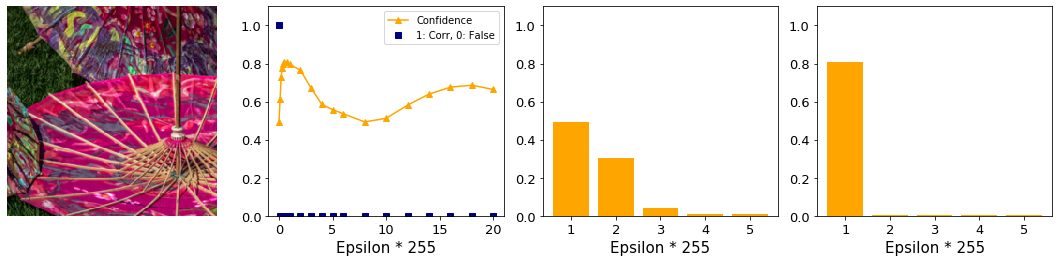

In [4]:
sample = 258
epsilon_conf = 0.5/255
analyze_attack_FGSM(data_loader, mean, std, model, predict, sample, epsilon_conf, 
                    show_tensor_image, idx_to_name, save_plot=True)

## References

[1] &emsp; Goodfellow et al. (2015) *Explaining and Harnessing Adversarial Examples*